Copyright 2019 Intel Corporation

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

# Introduction

In Lesson 6 of *Anomaly Detection*, we learned that if training data is available, supervised anomaly detection can be used, which converts the anomaly detection problem into a classification problem albeit one with special challenges. In the lecture we focused on one common challenge: class imbalance, which arises because anomalies are rare (by definition). 

Here will detect anomalies in simulated datasets using cost-sensitive learning, adaptive resampling and boosting methods.


# Learning Outcomes

You should walk away from this Python tutorial with:

1. An understanding of supervised anomaly detection 
2. Some practical experience with cost-sensitive learning, adaptive resampling and boosting methods.



# Imports

This notebook uses two packages that may require installation:

1. Mlxtend (machine learning extensions), which is a Python library of useful tools for data science tasks.
(http://rasbt.github.io/mlxtend/)


2. imbalance-learn, which is a Python package offering resampling techniques commonly used in datasets showing strong class imbalance
(https://imbalanced-learn.org/en/stable/index.html)

Installation instruction are below.

In [3]:
# %matplotlib inline
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
import sys
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import random
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from collections import Counter
from mlxtend.plotting import plot_decision_regions
from sklearn.metrics import confusion_matrix, accuracy_score
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier


Using TensorFlow backend.


# Python and library versions

In [4]:
versions = ( ("matplotlib", matplotlib.__version__),
            ("numpy", np.__version__),
            ("pandas", pd.__version__))

print(sys.version, "\n")
print("library" + " " * 4 + "version")
print("-" * 18)

for tup1, tup2 in versions:
    print("{:11} {}".format(tup1, tup2))

3.7.3 (default, Apr 24 2019, 15:29:51) [MSC v.1915 64 bit (AMD64)] 

library    version
------------------
matplotlib  3.1.0
numpy       1.16.4
pandas      0.24.2


# Section 1: Cost-sensitive learning

In this section, we are going to use simulated data to examine cost-sensitive learning. Our supervised anomaly detection will be done using a decision tree classifier (https://scikit-learn.org/stable/modules/tree.html#tree).

We will proceed as follows:

1. Create the simulated data
2. Train our algorithm giving all data points equal weight 
3. Examine the misclassifications using a confusion matrix 
4. Repeat steps (2) and (3) using cost-sensitive learning and compare our results.

### Data

We create the synthetic data using the *make_classification* function of sklean. We create 5000 points with approximately 90% normal points (label 0) and 10% anomalies (label 1). 

In [5]:
# Generate synthetic imbalanced data 
features, label = make_classification(n_samples=5000, n_features=2, 
                                      n_informative=2, n_redundant=0, 
                                      n_repeated=0, n_classes=2, 
                                      n_clusters_per_class=1,
                                      weights=[0.90, 0.10], flip_y=0.01,
                                      class_sep=1.5, random_state=42)


For a detailed explanation of the *make_classification* parameters, see https://scikitlearn.org/stable/modules/generated/sklearn.datasets.make_classification.html. 

Here we discuss a few of them.

We specify the initial weights of the normal and anomaly class to be 0.90 and 0.10 respectively using *weights*.

With *flip_y*, we specify the fraction of samples whose class are randomly exchanged to introduce some noise into the data.

And we use *class_sep* to specify the separation between the two classes; larger values spread out the classes. 

In [6]:
df = pd.DataFrame(features, columns=['feature1', 'feature2'])
df['label'] = label

Plot the data and color code normal vs. anomaly. Here we use *lmplot* from *seaborn* as it offers a compact way to label points by class.

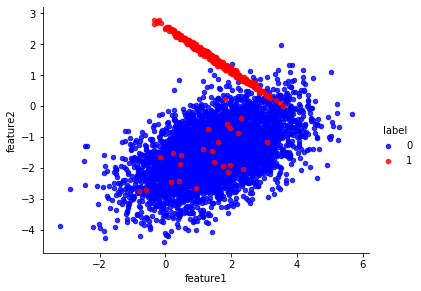

In [7]:
colors = ['blue', 'red']
sns.lmplot('feature1', 'feature2', data=df, hue='label',
           palette=colors, fit_reg=False, scatter_kws={'s': 20})
plt.gcf().set_size_inches(6,4);

Now, we train our classifier. We will use a decision tree with a single split (often called a decision stump). This tree makes a decision based on a single input feature.

In [8]:
# Plain tree as 
tree_plain = DecisionTreeClassifier(max_depth=1, class_weight=None)

We will use *plot_decision_regions* from *mlxtend* to show the regions the classfier uses to assign class labels.

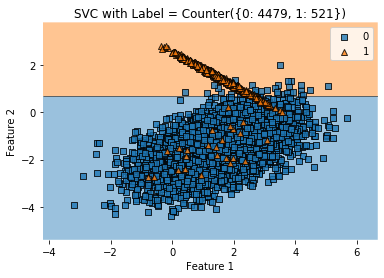

In [9]:
tree_plain_fit = tree_plain.fit(features, label)
plot_decision_regions(features, label, tree_plain_fit)
plt.title(f'SVC with Label = {Counter(label)}')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(loc='best')
plt.gcf().set_size_inches(6,4)

As expected, the two classes are separated by a single line as only one feature was used for the split. 

Next, we examined the statistics of the classification.

In [10]:
cm_tree_plain=confusion_matrix(label, tree_plain.predict(features))
print(cm_tree_plain)
accuracy_tree_plain = accuracy_score(label, tree_plain.predict(features))
print(f'Accuracy: {accuracy_tree_plain}')

[[4442   37]
 [  47  474]]
Accuracy: 0.9832


We misclassified 37 normal points and 47 anomalies. Not bad, but let's try to improve this result.

To do so, we will introduce cost-sensitive learning. For our decision tree, cost-sensitive learning can be introduced through the parameter *class_weight*. In the previous analysis, this parameter was set to *None*, which means that all points were given equal weight. 

In our next iteration, we will set *class_weight* to *balanced*. In this case, the weights are set inversely proportional to the frequency of the class. That is, the cost of making a mistake is inversely proportional to the number of instances of that class, which is the example we discussed in the lecture. 

For more details, see https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier

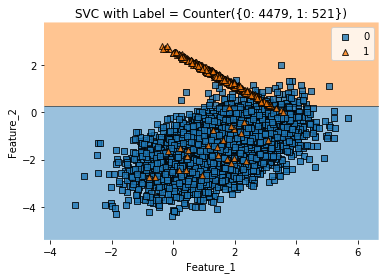

In [11]:
tree_bal = DecisionTreeClassifier(max_depth=1, class_weight='balanced')
tree_bal_fit = tree_bal.fit(features, label)
plot_decision_regions(features, label, tree_bal_fit)
plt.title(f'SVC with Label = {Counter(label)}')
plt.xlabel('Feature_1')
plt.ylabel('Feature_2')
plt.legend(loc='best')
plt.gcf().set_size_inches(6,4)

Notice that the boundary has moved. It is now closer to Feature_2 = 0. This is promising. It shows that the cost-sensitive learning has had an effect on the classification. Is it for the better?

In [12]:
cm_tree_bal=confusion_matrix(label, tree_bal.predict(features))
print(cm_tree_bal)
accuracy_tree_bal = accuracy_score(label, tree_bal.predict(features))
print(f'Accuracy: {accuracy_tree_bal}')

[[4381   98]
 [  27  494]]
Accuracy: 0.975


The accuracy has dropped and we misclassified more normal points (98 vs. 37 previously). 

However, we improved our classification of anomalies. Only 27 were misclassified (vs. 47 before). If what matters most to us are the anomalies, the lower misclassification rate is a significant improvement.

Cost-sensitive learning is doing what it is meant to do: help detect anomalies. 

# Section 2: Adaptive resampling 

In this section, we are going to use the data from the previous section to illustrate the adaptive resampling. Our supervised anomaly detection will be done using support vector classification—SVC (https://scikit-learn.org/stable/modules/svm.html#svm-classification).


We will proceed as we did before:

1. Train our anomaly detection algorithm without any resampling 
2. Calculate the cost of our misclassification
3. Repeat steps (2) and (3) using adaptive resampling and compare our results.

First, we build our classifier using the training dataset. 

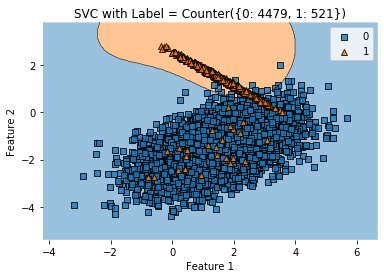

In [13]:
clf = SVC().fit(features, label)
plot_decision_regions(features, label, clf)
plt.title(f'SVC with Label = {Counter(label)}')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(loc='best')
plt.gcf().set_size_inches(6,4)

We see (from the title of the plot) that we have 521 anomalies and 4479 normal points. That is, 10.4% of the points are anomalies. 

Let's look at the confusion matrix to see how well our classifier works.

In [14]:
cm=confusion_matrix(label, clf.predict(features))
print(cm)

[[4457   22]
 [  47  474]]


To make things clearer, we print out each category.

In [15]:
tn, fp, fn, tp = cm.ravel()
print(f'True Negative: {tn}')
print(f'False Positive: {fp}')
print(f'False Negative: {fn}')
print(f'True Positive: {tp}')
accuracy = accuracy_score(label, clf.predict(features))
print(f'Accuracy: {accuracy}')

True Negative: 4457
False Positive: 22
False Negative: 47
True Positive: 474
Accuracy: 0.9862


In other words, we misclassified 18 normal points and 40 anomalies. Can we do better?

### Oversampling

As a first attempt to improve, let's oversample the anomaly class. We will use *RandomOverSampler* from *imblearn* to created a resampled training dataset. 

Essential input: how much we want to oversample the anomaly class. Here we will specify the oversampling as a fraction of the size of the normal class. This fraction, *resample_ratio*, should meet two conditions:

1. It should be less than or equal to 1, so that the anomaly class always remain a minority. 

2. The fraction should be large enough than the number of anomaly points in the resampled dataset is larger that the number in the original dataset. Otherwise, we will be undersampling the anomaly class.

Violating either condition produces a warning. 

In [17]:
# Random oversampling of the anomaly class
resample_ratio = 0.3 # (anomalies / normal) after resampling
sample_normal = tn + fp # total number of true normal points
sample_anomaly = int(resample_ratio*sample_normal) # must be an integer
sampling_dict = {0: sample_normal, 1: sample_anomaly}
# ros = RandomOverSampler(ratio=sampling_dict, random_state=0) #original line
ros = RandomOverSampler( random_state=0) #I deleted ratio=...
features_resampled, label_resampled = ros.fit_sample(features,label)

Show how many points in each class after resampling

In [18]:
Counter(label_resampled)

Counter({0: 4479, 1: 4479})

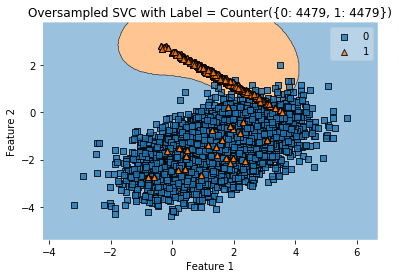

In [19]:
clf_ros = SVC().fit(features_resampled, label_resampled)
plot_decision_regions(features_resampled, label_resampled, clf_ros)
plt.title(f'Oversampled SVC with Label = {Counter(label_resampled)}')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.gcf().set_size_inches(6,4)

As before, we show the confusion matrix and individual categories for our predictions.

In [20]:
cm_ros = confusion_matrix(label, clf_ros.predict(features))
cm_ros

array([[4412,   67],
       [  27,  494]], dtype=int64)

In [21]:
tn_ros, fp_ros, fn_ros, tp_ros = cm_ros.ravel()
print('After Random Oversampling')
print(f'True Negative: {tn_ros}')
print(f'False Positive: {fp_ros}')
print(f'False Negative: {fn_ros}')
print(f'True Positive: {tp_ros}')
accuracy_ros = accuracy_score(label, clf_ros.predict(features))
print(f'Accuracy: {accuracy}')

After Random Oversampling
True Negative: 4412
False Positive: 67
False Negative: 27
True Positive: 494
Accuracy: 0.9862


Now have misclassified 28 normal points and 34 anomalies.

Previously, we misclassified 18 normal points and 40 anomalies. 

Which is better? 

The answer depends on the cost of misclassification. 

Let us define a function that calculates this cost. In the function below, we are implicitly assuming that a correctly classified point has no cost.

In [22]:
def misclass_cost(false_pos, false_neg, false_pos_cost, false_neg_cost):
    '''
    Calculates the cost of misclassified instances
   
    Args: 
        false_pos: number of false positives (float)
        false_neg: number of false negatives (float)
        false_pos_cost: cost of a false positive (float > 0)
        false_neg_cost: cost of a false negative (float > 0)
        
    Returns: 
        misclass_cost: the cost of misclassifcation (float)
        
    Raises:
        Error: if false_pos_cost or false_neg_cost are non-positive
    '''
    if(false_pos_cost <= 0  or false_neg_cost <= 0):
        print('Costs must be greater than zero')
        return
    else:
        misclass_cost = (false_pos*false_pos_cost 
                         + false_neg*false_neg_cost)
        return misclass_cost

Now to assign costs. We will follow the approach described in the lecture for the screening test, where the cost for a false negative is greater than for a false positive. 

In [23]:
false_pos_cost = 10
false_neg_cost = 100

Finally, we can calculate the cost from the regular dataset and the randomly oversampled one.

In [24]:
cost_reg = misclass_cost(fp, fn, false_pos_cost, false_neg_cost)
cost_ros = misclass_cost(fp_ros, fn_ros, false_pos_cost, false_neg_cost)
print(f'Without oversampling the cost is: {cost_reg}')
print(f'With random oversampling the cost is: {cost_ros}')
print('')
print(f'Accuracy without oversampling is: {accuracy}')
print(f'Accuracy with random oversampling is: {accuracy_ros}')

Without oversampling the cost is: 4920
With random oversampling the cost is: 3370

Accuracy without oversampling is: 0.9862
Accuracy with random oversampling is: 0.9812


Random oversampling has reduced the cost of misclassification despite the lower accuracy.

**Question**: What happens if the costs for false positive and false negative are equal?

**Answer**: The cost will be proportional to (1-accuracy). In other words, using accuracy as a metric is equivalent to assuming equal costs for the two categories. 

### Undersampling

Let's see how undersampling does. The structure of this section is the same as for oversampling, except that now we undersample the normal class.

As before, we have an essential input: how much we want to undersample the normal class. Here we will specify the undersampling as a multiple of the size of the anomaly class. This multiple, *resample_ratio_under*, should meet two conditions:

1. It should be greater than or equal to 1, so that the normal class always remain a majority. 

2. The multiple should be small enough than the number of normal points in the resampled dataset is smaller that the number in the original dataset. Otherwise, we will be oversampling the normal class.

In [26]:
# Random undersampling of the normal class

# resample_ratio_under is (normal/anomalies) after resampling
# Should be int, but added int() later to prevent error
resample_ratio_under = 1 # a 1:1 ratio is a typical starting point

sample_anomaly_under = tp + fn 

# total number of true normal points
# int is a safeguard in case resample_ratio_under is given as float
sample_normal_under = int(resample_ratio_under*sample_anomaly_under)

sampling_dict = {0: sample_normal_under, 1: sample_anomaly_under}
# rus = RandomUnderSampler(ratio=sampling_dict, random_state=0) #original line
rus = RandomUnderSampler(random_state=0) #I deleted ratio=...
features_resampled_2, label_resampled_2 = rus.fit_sample(features,label)

In [27]:
# Check undersampling 
Counter(label_resampled_2)

Counter({0: 521, 1: 521})

For simplicity, omit plot and just calculate statistics

In [28]:
clf_rus = SVC().fit(features_resampled_2, label_resampled_2)

In [29]:
cm_rus = confusion_matrix(label, clf_rus.predict(features))
print(cm_rus)
accuracy_rus = accuracy_score(label, clf_rus.predict(features))
tn_rus, fp_rus, fn_rus, tp_rus = cm_rus.ravel()
cost_rus = misclass_cost(fp_rus, fn_rus, false_pos_cost, false_neg_cost)
print('')
print(f'With random undersampling the cost is: {cost_rus}')
print(f'Accuracy with random undersampling is: {accuracy_rus}')

[[4388   91]
 [  27  494]]

With random undersampling the cost is: 3610
Accuracy with random undersampling is: 0.9764


Undersampling does even better than oversampling in terms of cost despite the further drop in accuracy.

# Section 3: AdaBoost


In this section, we are going to examine boosting methods. More specifically, we will look at adaptive boosting (AdaBoost). 

As we discussed in the lecture, AdaBoost works well with any weak learner, but it most commonly used with decision trees. Therefore, it this section we will apply it to the plain tree from Section 1 (where *class_weight* is *None*) and see if it improves our results. 

In [30]:
bdtree = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1, 
                                                   class_weight=None),
                            n_estimators=100)

AdaBoost introduces extra paramaters that must be specified. The only parameter we will change from the default value is *n_estimators*, which is the maximum number of estimators at which boosting is terminated.

A complete list of parameters is here: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#sklearn.ensemble.AdaBoostClassifier

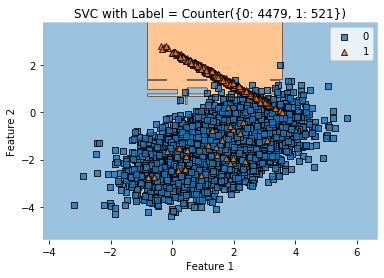

In [31]:
bdtree_fit = bdtree.fit(features, label)
plot_decision_regions(features, label, bdtree_fit)
plt.title(f'SVC with Label = {Counter(label)}')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(loc='best')
plt.gcf().set_size_inches(6,4)

AdaBoost has created a more complex decision boundary. It is no longer a single straight line. Have the statistics improved too?

In [32]:
cm_bdtree=confusion_matrix(label, bdtree.predict(features))
print(cm_bdtree)
accuracy_bdtree = accuracy_score(label, bdtree.predict(features))
print(f'Accuracy: {accuracy_bdtree}')

[[4460   19]
 [  43  478]]
Accuracy: 0.9876


Recall the results without boosting

In [33]:
print(cm_tree_plain)
print(f'Accuracy: {accuracy_tree_plain}')

[[4442   37]
 [  47  474]]
Accuracy: 0.9832


Boosting has increased the accuracy and even improved slightly the number of anomalies detected correctly (478 vs. 474) Useful!

### Exercise #1

This exercise refers to Section 2 (adaptive resampling). 

We found that undersampling gave the lowest cost of misclassification for the costs we specified. However, we did not check whether our undersampling ratio was optimal. Could a different value *resample_ratio_under* lower our cost even more?

Write a function to calculate the misclassification cost for a suitable range of *resample_ratio_under* and find the ratio that leads to the lowest cost.

### Solution #1

In [34]:
# YOUR CODE HERE

### Exercise #2

This exercise refers to Section 3 (AdaBoost).

Repeat the analysis of Section 3 with the balanced decision trees (*class_weight*=*balanced*). Does boosting lead again to an improvement is anomaly detection?

### Solution #2

In [35]:
# YOUR CODE HERE

# Summary

In this assignment you should have learned: 

1. How to use supervised anomaly detection
2. How to implement cost-sensitive learning, adaptive resampling and boosting methods.

Congratulations! This concludes the lesson.

In [36]:
print('end')

end
